In [1]:
%env THEANO_FLAGS=device=gpu1,floatX=float32
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

theano.config.compute_test_value = "off"

env: THEANO_FLAGS=device=gpu1,floatX=float32


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K80 (CNMeM is enabled with initial size: 22.0% of memory, cuDNN not available)


# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [57]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [58]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

('n samples = ', 7944)
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [59]:
#all unique characters go here
tokens = []

for name in names:
    for char in name:
        if char not in tokens:
            tokens.append(char)

print ('n_tokens = ',len(tokens))


('n_tokens = ', 55)


In [60]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

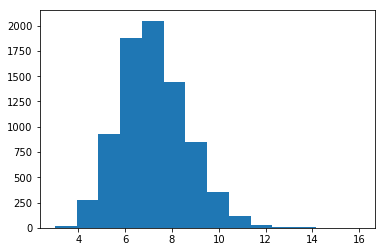

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,names)),bins=14);



In [62]:
# truncate names longer than MAX_LEN characters. 
MAX_LEN = 12

#you will likely need to change this for any dataset different from "names"


### Cast everything from symbols into identifiers

In [63]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

In [64]:
names_ix.shape, names_ix[:5]

((7944, 12), array([[0, 1, 2, 3, 4, 3, 5, 6, 0, 0, 0, 0],
        [0, 1, 2, 3, 4, 3, 7, 6, 0, 0, 0, 0],
        [0, 1, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 2, 5, 8, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 2, 7, 0, 0, 0, 0, 0, 0, 0]]))

In [65]:
names[:10]

[' Abagael',
 ' Abagail',
 ' Abbe',
 ' Abbey',
 ' Abbi',
 ' Abbie',
 ' Abby',
 ' Abigael',
 ' Abigail',
 ' Abigale']

# Input variables

In [66]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [2]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer,DropoutLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer
from lasagne.nonlinearities import tanh, elu, rectify, sigmoid

In [68]:
#l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)
#l_emb = EmbeddingLayer(l_in, input_size=len(tokens), output_size=4)

#output = lasagne.layers.get_output(l_emb, input_sequence)
#f = theano.function([input_sequence], output)

#output = f(names_ix[:3].astype('int32'))
#output.shape, output

In [91]:
l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)
l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 
l_emb = EmbeddingLayer(l_in, input_size=len(tokens), output_size=32)
#l_rnn = RecurrentLayer(l_emb, num_units=8) # observation, token_len, hidden_len
#l_rnn2 = RecurrentLayer(l_rnn, num_units=8)
#l_gru = GRULayer(l_emb, num_units=32, n)
#l_gru2 = GRULayer(l_gru, num_units=32)
l_rnn = GRULayer(l_emb, num_units=32, mask_input=l_mask, grad_clipping=20)
l_rnn2 = GRULayer(l_rnn, num_units=32, mask_input=l_mask, grad_clipping=20)

# flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1, l_rnn2.output_shape[-1]))
# <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_hidden = DenseLayer(l_rnn_flat, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
#l_dropout = DropoutLayer(l_hidden, p=0.2)
l_hidden2 = DenseLayer(l_hidden, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
l_out = DenseLayer(l_hidden2, num_units=len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [92]:
#output = lasagne.layers.get_output(l_rnn, input_sequence)
#f = theano.function([input_sequence], output)
#out = f(names_ix[:3].astype('int32'))
#out.shape, out

In [93]:
#output = lasagne.layers.get_output(l_rnn_flat, input_sequence)
#f = theano.function([input_sequence], output)
#out = f(names_ix[:3].astype('int32'))
#out

In [94]:
# get network output (probas of each letter)
network_output = lasagne.layers.get_output(l_out)

# get network weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)

# set loss function, pass predictions and true values
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()
loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

# set optimization procedure
updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [95]:
# training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

# computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [96]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [97]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '\n'.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [98]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [99]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=100


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  gCQPoDJVXKGs
 lfQXkbia ZQn
 cLllRfoNoiJD
 ZtXVoCQgDhQc
 jechoSgYNNwd
 tMudTTiEqfUA
 qlMplzQkrqpc
 YdJFVrvIyDow
 WnTtETrPRP-j
 RGjfKtsMEVkw 
----
Epoch 0 average loss = 1.75096793962
Generated names
----
  Parnir      
 Morendsl    
 Pebaasy     
 Vynseed     
 Alryan      
 Coele       
 Mres        
 Jastalqy    
 Milile      
 Minylr       
----
Epoch 1 average loss = 1.50832091498
Generated names
----
  Meroy       
 Jalend      
 Mincev      
 Sotrom      
 Warry       
 Pharhaid    
 Jellujo     
 Meres       
 Kati        
 Aleree       
----
Epoch 2 average loss = 1.45013418341
Generated names
----
  Maongele    
 Josay       
 Arhanyst    
 Drina       
 Jann        
 Elanel      
 Martoi      
 Tynao       
 Merlal      
 Mosdy        
----
Epoch 3 average loss = 1.40625092292
Generated names
----
  Hittrie     
 Imell       
 Zinana      
 Clagtriag   
 Syach       
 Colloh      
 Frubyra     
 Chachr      
 Girxifl     
 Chelliuctta  
----

In [89]:

print("Training ...")


#total N iterations
n_epochs=200

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=100


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  EquLPQCkLtj'
 YDROZQW-IZSg
 fZKpbrkzQEXv
 xoHv-oOoyPuq
 x'bULSQCiUKg
 lWBfDsfnnCky
 wkgGBWpE-WhG
 NBulGsS gGiF
 Peu-IUzxedWT
 F a-lOvGxwNu 
----
Epoch 0 average loss = 1.81746863222
Generated names
----
  Kinmoana    
 Zolhelh     
 Labcere     
 Inciide     
 Mlanue      
 Lerrir      
 Balete      
 Thene       
 Rarhenes    
 Barta        
----
Epoch 1 average loss = 1.53735048509
Generated names
----
  Hitroy      
 Molhenli    
 Rinalit     
 Narrie      
 Srirer      
 Tehso       
 Henlale     
 Jolona      
 Ntyryn      
 Banty        
----
Epoch 2 average loss = 1.50048454666
Generated names
----
  Lany        
 Crlolnic    
 Orpel       
 Bon         
 Boyd        
 Cayrer      
 Marko       
 Eloy        
 Rocina      
 Szesnella    
----
Epoch 3 average loss = 1.46529112744
Generated names
----
  Perial      
 Aswa        
 Juvar       
 Renen       
 Ficr        
 Chrarsy     
 Pode        
 Cleai       
 Esnam       
 Alra         
----

In [90]:
generate_sample(n_snippets=100)

----
  Ventum      
 Sammie      
 Ephraim     
 Bery        
 Pen         
 Isaiah      
 Ford        
 Berry       
 Leese       
 Suzann      
 Agnhmarie   
 Helen-Elize 
 Clem        
 Shela       
 Cheston     
 Dulcia      
 Nelli       
 Zippy       
 Alexi       
 Herby       
 Bogart      
 Opaline     
 Nero        
 Miles       
 Aime        
 Anny        
 Roslyn      
 Lin         
 Cindy       
 Dorey       
 Rhianon     
 Arlinda     
 Leland      
 Rey         
 Nona        
 Allie       
 Kerianne    
 Thorpe      
 Don         
 Colleenca   
 Velva       
 Torrey      
 Jada        
 Glenna      
 Jef         
 Maribel     
 Fredelia    
 Tiedra      
 Demetris    
 Neron       
 George      
 Elsa        
 Catina      
 Berna       
 Nedda       
 Helga       
 Cherri      
 Koralle     
 Agby        
 Camala      
 Linnet      
 Zenia       
 Brendania   
 Arma        
 Delia       
 Zacharie    
 Grata       
 Bartlet     
 Kent        
 Alastair    
 Standford   


In [59]:
generate_sample(seed_phrase=" A",n_snippets=10)

----
  Aeri         ;  Annabal      ;  Adrianna     ;  Audre        ;  Adoree       ;  Asiles       ;  Augustina    ;  Annecorinne  ;  Arthur       ;  Auria         
----


In [60]:
generate_sample(seed_phrase=" Va",n_snippets=10,t=1.0)

----
  Valera        ;  Vasilis       ;  Vaugha        ;  Valentina     ;  Valenka       ;  Valera        ;  Vaughann      ;  Valina        ;  Valry         ;  Vanya          
----


## Homework part 1 - generate questions (4 pts)

* Apply recurrent neural networks to generate human-readable questions.
* The dataset origins from https://www.kaggle.com/c/quora-question-pairs - a recent kaggle challenge.
* The code below shows how to read the dataset
* Please download the __train dataset__ from [here](https://www.kaggle.com/c/quora-question-pairs/data)
* Avoid using test dataset as it contains artificially generated data.
* Alternatively, pick any similar dataset you like.

In [3]:
import pandas as pd
df = pd.read_csv("../../data/week6.5/train.csv")
df = pd.concat([df.question1, df.question2])

questions = list(set(df))
questions = filter(lambda x: type(x) is str, questions)
start_token, end_token = " ", "|"
questions = [start_token + name + end_token for name in questions]

print('n samples = ',len(questions))
for x in questions[::100000]:
    print (x)

('n samples = ', 537361)
 What is admirable about Scarface?|
 How do you work with incompetent co-workers?|
 What exactly is hard work?|
 Where can I legally watch Dragon Ball Z episodes and movies?|
 Why does the soccer goalkeeper wear number 1?|
 What are some free art residencies for emerging artists?|


## Text processing

In [129]:
# all unique words, w/ simple regex tokenizer
token_set = set()

for question in questions:
    for word in question:
        token_set.add(word)

tokens = list(token_set)

print 'n_tokens = ', len(tokens)

n_tokens =  198


In [130]:
names = list(questions)

In [103]:
import re

names = []
for question in questions:
    names.append([item.lower() for item in re.findall(r"[\w']+|[.,!?;]|\<start>|\<end>", question)])
    
names

[['what', 'is', 'admirable', 'about', 'scarface', '?'],
 ['i',
  'am',
  '25',
  'yrs',
  'old',
  'girl',
  'and',
  'i',
  'don',
  't',
  'get',
  'my',
  'periods',
  'on',
  'time',
  '.',
  'what',
  'is',
  'the',
  'best',
  'way',
  'to',
  'regularize',
  'menstrual',
  'cycle',
  '.'],
 ['what', 'is', 'molecular', 'orbital', 'method', '?'],
 ['what', 'is', 'an', 'optimal', 'binary', 'search', 'tree', '?'],
 ['what',
  'is',
  'the',
  'difference',
  'between',
  'continuous',
  'and',
  'discrete',
  'data',
  '?'],
 ['is',
  'there',
  'any',
  'difference',
  'between',
  'the',
  'syllabus',
  'of',
  'sbi',
  'po',
  'and',
  'rbi',
  'assistant',
  '?'],
 ['how',
  'dangerous',
  'would',
  "trump's",
  'china',
  'policy',
  'be',
  'for',
  'the',
  'world',
  'economy',
  '?'],
 ['how', 'to', 'be', 'less', 'self', 'conscious', '?'],
 ['can',
  'i',
  'use',
  'reliance',
  'jio',
  'sim',
  'on',
  'any',
  'lte',
  'phone',
  'after',
  'the',
  'initial',
  'activ

In [104]:
names[:5]

[['what', 'is', 'admirable', 'about', 'scarface', '?'],
 ['i',
  'am',
  '25',
  'yrs',
  'old',
  'girl',
  'and',
  'i',
  'don',
  't',
  'get',
  'my',
  'periods',
  'on',
  'time',
  '.',
  'what',
  'is',
  'the',
  'best',
  'way',
  'to',
  'regularize',
  'menstrual',
  'cycle',
  '.'],
 ['what', 'is', 'molecular', 'orbital', 'method', '?'],
 ['what', 'is', 'an', 'optimal', 'binary', 'search', 'tree', '?'],
 ['what',
  'is',
  'the',
  'difference',
  'between',
  'continuous',
  'and',
  'discrete',
  'data',
  '?']]

In [105]:
# all unique words, w/ simple regex tokenizer
token_set = set()
token_set.add("<pad>")

for name in names:
    for word in name:
        token_set.add(word)

tokens = list(token_set)

print 'n_tokens = ', len(tokens)

n_tokens =  92003


In [131]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

In [135]:
id_to_token[0]

'\x83'

In [133]:
MAX_LEN = 100

names_ix = list(map(lambda name: list(map(token_to_id.get, name)), names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

names_ix.shape, names_ix[:5], names[:5]

((537361, 100),
 array([[  8,  83,  42, 187,  47,   8, 191,  95,   8, 187,  40, 193, 191,
         144, 187, 137,  44, 189,   8, 187, 137,  94, 195,  47,   8,  82,
          88, 187, 144, 139, 187,  88, 189,  73,  49,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8],
        [  8, 176,   8, 187, 193,   8, 117, 166,   8, 196, 144,  95,   8,
          94,  44,  40,   8,  90, 191, 144,  44,   8, 187, 143,  40,   8,
         176,   8,  40,  94, 143, 188,  50, 106,  47,   8,  90, 189,  47,
           8, 193, 196,   8,  46, 189, 144, 191,  94,  40,  95,   8,  94,
         143,   8,  47, 191, 193, 189, 115,   8,  83,  42, 187,  47,   8,
         191,  95,   8,  47,  42, 189,   

## Building a model

In [136]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)
#l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 
l_emb = EmbeddingLayer(l_in, input_size=len(tokens), output_size=32)
l_rnn = GRULayer(l_emb, num_units=32, grad_clipping=20)
l_rnn2 = GRULayer(l_rnn, num_units=32, grad_clipping=20)
#l_rnn3 = GRULayer(l_rnn2, num_units=32, grad_clipping=5)

# flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1, l_rnn2.output_shape[-1]))
# <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_hidden = DenseLayer(l_rnn_flat, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
#l_dropout = DropoutLayer(l_hidden, p=0.2)
l_hidden2 = DenseLayer(l_hidden, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
l_out = DenseLayer(l_hidden2, num_units=len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [137]:
# get network output (probas of each letter)
network_output = lasagne.layers.get_output(l_out)

# get network weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)

# set loss function, pass predictions and true values
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()
loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

# set optimization procedure
updates = lasagne.updates.adam(loss, weights)

In [138]:
# training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

# computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

In [139]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [12]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("\n".join(snippets))
    print("---\n")


In [13]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [142]:
print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=100


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=5)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
 ib�+qr�Pf�lA�-Ҙ�0�4ѿ:6%ZL��eȹ�l���-rh�>�>Q$�s*��~ȱ���֤-�[����~�咘ʥ�6�)v#�K�^��ɠK�K���s{m6�w
 ����A.�.`�PgZ��?GG+9��r��Y���3ŕ�|О��J틁)�P��Z�\S��Rvqx�JkL '*KuI�s� .�;�S�Jh�w�~I���_h0�ig(���sq
 �d!jfV�ـ�)S`�>�C#�bv�����ʛOu� 1�ھ���g~E6RT����v�Q�Ѓ��_=ɎA#�<Q�OM�}W%�RFQ�6zo!����-���e��lMv�'H
 �'I<�rM�5&`-ۜ�緰xq�]'=�q�(���@YTK��g&��3�o����LM58x��-A�g��A��J��L��AFZ>�Z�J�"k#��R�@G w>�zgx�
 �ј�,�yYt���I�~6:��œ�$J�P�i�U֕��l��Z�剏zKҲ'��"Cd]zbS�z(Klŷ/��#��E��Ed�f.&zK�B{�!DڴJaNqg�9�a
---

Epoch 0 average loss = 1.7460098362
Generated names
 I Hach dice my ifmlec eperpacusod inthale yowhe ansig irte ing gengpemio10 in foupnd ben memof thin 
 Whaterave indien puntere ma-st Mokrismy cop frind wod peCt. Cosint yor of hetareite toa ve alilgmant
 How cit Doc I moprre?|                                                                              
 What I dhe ans 39s terte the won ssee vist, naste meniz. caran there pachit ya lualize Mhetot veunle
 Hhe saco a Mhitwe thir K.SEP8 M

### [bonus] Word-level model (4+ points)

Learn to generate questions on _word_ level, generating one word per RNN iteration.

Kudos for 
* pre-training embedding layer with word2vec or similar
* using more compute-efficient softmax functions (hierarchical or sampled softmax)
* anything creative :)

### Hierarchical softmax:

- https://www.youtube.com/watch?v=B95LTf2rVWM
- https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d

In [21]:
from hierarchical_softmax import HierarchicalSoftmaxDenseLayer

## Text processing

In [4]:
import re

names = []
for question in questions:
    names.append([item.lower() for item in re.findall(r"[\w']+|[.,!?;]|\<start>|\<end>", question)])
    
names

[['what', 'is', 'admirable', 'about', 'scarface', '?'],
 ['i',
  'am',
  '25',
  'yrs',
  'old',
  'girl',
  'and',
  'i',
  'don',
  't',
  'get',
  'my',
  'periods',
  'on',
  'time',
  '.',
  'what',
  'is',
  'the',
  'best',
  'way',
  'to',
  'regularize',
  'menstrual',
  'cycle',
  '.'],
 ['what', 'is', 'molecular', 'orbital', 'method', '?'],
 ['what', 'is', 'an', 'optimal', 'binary', 'search', 'tree', '?'],
 ['what',
  'is',
  'the',
  'difference',
  'between',
  'continuous',
  'and',
  'discrete',
  'data',
  '?'],
 ['is',
  'there',
  'any',
  'difference',
  'between',
  'the',
  'syllabus',
  'of',
  'sbi',
  'po',
  'and',
  'rbi',
  'assistant',
  '?'],
 ['how',
  'dangerous',
  'would',
  "trump's",
  'china',
  'policy',
  'be',
  'for',
  'the',
  'world',
  'economy',
  '?'],
 ['how', 'to', 'be', 'less', 'self', 'conscious', '?'],
 ['can',
  'i',
  'use',
  'reliance',
  'jio',
  'sim',
  'on',
  'any',
  'lte',
  'phone',
  'after',
  'the',
  'initial',
  'activ

In [5]:
# all unique words, w/ simple regex tokenizer
token_set = set()
token_set.add("<pad>")

for name in names:
    for word in name:
        token_set.add(word)

tokens = list(token_set)

print 'n_tokens = ', len(tokens)

n_tokens =  92003


In [6]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

In [10]:
MAX_LEN = 32

names_ix = list(map(lambda name: list(map(token_to_id.get, name)), names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id["<pad>"]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

names_ix.shape, names_ix[:5], names[:5]

((537361, 32),
 array([[14386, 14194, 23801, 77175, 88416, 74227, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873],
        [10026, 12591, 30069, 48616, 80815, 40989, 44512, 10026, 74740,
         72825, 40904, 61679, 54171, 21115, 34962,   466, 14386, 14194,
         60452, 11590, 72120, 69918,    12, 84032, 55573,   466, 43873,
         43873, 43873, 43873, 43873, 43873],
        [14386, 14194, 82008, 16723, 35719, 74227, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873],
        [14386, 14194, 12594, 69329, 23822, 18402, 22876, 74227, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873, 43873,
         43873, 43873, 43873, 43873, 43873, 43873, 43873, 

## Building a model

In [32]:
grad_clipping = 20 

input_sequence = T.matrix('token sequencea', 'int32')
target_values = T.matrix('actual next token', 'int32')

l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)
#l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence, -1)) 
l_emb = EmbeddingLayer(l_in, input_size=len(tokens), output_size=32)
l_rnn = GRULayer(l_emb, num_units=32, grad_clipping=grad_clipping)
l_rnn2 = GRULayer(l_rnn, num_units=32, grad_clipping=grad_clipping)

# flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1, l_rnn2.output_shape[-1]))
# <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_hidden = DenseLayer(l_rnn_flat, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
l_hidden2 = DenseLayer(l_hidden, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
#l_out = DenseLayer(l_hidden2, num_units=len(tokens), nonlinearity=lasagne.nonlinearities.softmax)
l_out = HierarchicalSoftmaxDenseLayer(l_hidden2, len(tokens))

In [33]:
# get network output (probas of each letter)
network_output = lasagne.layers.get_output(l_out)

# get network weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)

# set loss function, pass predictions and true values
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()
loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()
#loss_hier = network_output.mean()
loss_hier = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

# set optimization procedure
updates = lasagne.updates.adam(loss, weights)

In [39]:
# training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)
train_hier = theano.function([input_sequence, target_values], loss_hier, updates=updates, allow_input_downcast=True)

# computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss_hier, allow_input_downcast=True)

In [40]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [41]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ' '.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("\n".join(snippets))
    print("---\n")


In [42]:
print("Training ...")

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 100

#how many training sequences are processed in a single function call
batch_size=10

for epoch in range(n_epochs):

    print( "Generated sentences")
    generate_sample(n_snippets=5)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train_hier(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))

Training ...
Generated sentences
 be bags of <pad> , hybridisation of ceasefire <pad> <pad> <pad> ? <pad> <pad> <pad> <pad> <pad> ? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 can ongc can for soldier's city for ? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 girl best don't with fleetwood <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 convergence <pad> ? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 in aghoris do i is ? about ? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
---

Epoch 0 average loss = 2.74982066